<font color="#e32b3d"><h1>Conditional DCGAN</h2></font>

<font color="#822b34"><h2>*MedMNIST Dataset* -> Breast MNIST</h2></font>

# **part 1: Importing Datasets and ResNet**
required library and packages are imported.

*   Loading dataset and pre-processing
*   Classifying BreastMNIST using ResNet50.




In [1]:
## installing menmnist
!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116932 sha256=82f1eb39dd95e3f27186f4077e7f3879e7eb35472fafdc0496efc1554da182f0
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire


In [2]:
# Import library
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
import medmnist
from medmnist import INFO, Evaluator
data_flag = 'breastmnist'
download = True
BATCH_SIZE = 128

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])
## getting Breast mnist
DataClass = getattr(medmnist, info['python_class'])

In [4]:
# Data preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])])

# loading the data (train, test, validation)
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)
val_dataset = DataClass(split='val', transform=data_transform, download=download)


100%|██████████| 559580/559580 [00:00<00:00, 924295.81it/s]

Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz


In [5]:
# dataset info
train_dataset

Dataset BreastMNIST (breastmnist)
    Number of datapoints: 546
    Root location: /root/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'malignant', '1': 'normal, benign'}
    Number of samples: {'train': 546, 'val': 78, 'test': 156}
    Description: The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.
    License: CC BY 4.0

In [6]:
## checking the imbalancy#checking the imbalancy
print(f'all train data:{train_dataset.labels.shape[0]}\nnumber of data in class 1 : {sum(train_dataset.labels.squeeze())}\nnumber of data in class 0 : {train_dataset.labels.shape[0] - sum(train_dataset.labels.squeeze())}')

all train data:546
number of data in class 1 : 399
number of data in class 0 : 147


In [7]:
classes = { 'malignant','normal, benign'}

In [8]:
## creating Train dataset in form of a list
def create_dataset (dataset):
  Dset = []
  for i in range(dataset.imgs.shape[0]):
    data = torch.tensor(dataset.imgs[i])
    if(dataset.labels[i] == 1):
      label = torch.tensor([0,1])
    else:
      label = torch.tensor([1,0])

    m = {'label': label,
        'img':data}
    Dset.append(m)
  return Dset

Train_set = create_dataset(train_dataset)
Test_set = create_dataset(test_dataset)
Val_set = create_dataset(val_dataset)

Text(0.5, 1.0, 'Sample data from train set with label = tensor([0, 1])')

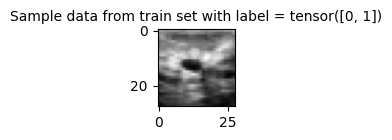

In [9]:
# Visualising the sample data from Train_set
plt.figure(figsize=(1, 1))
_ = plt.imshow(Train_set[5]['img'], cmap='gray')
plt.title(f"Sample data from train set with label = {Train_set[5]['label']}", fontsize=10)

In [10]:
# encapsulate data into dataloader form
train_loader = DataLoader(dataset=Train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=Val_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=Test_set, batch_size=BATCH_SIZE, shuffle=True)

In [11]:
## Importing pre-trained ResNet50
import torchvision.models as models
resnet50 = models.resnet50(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 78.6MB/s]


In [12]:
## Modifying ResNet to match our data
resnet50.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7),
                      stride=(2, 2), padding=(3, 3), bias=False)
in_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(in_features=in_ftrs, out_features=2, bias=True)

In [13]:
#RESNET INFO
resnet50

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [14]:
## Creating a class for ResNet50
class resnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet_50 = resnet50
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        y = self.resnet_50(x)
        y = self.softmax(y)
        return y

In [15]:
## Accuracy function
def accuracy_fn(true, pred):
  acc = 0.00
  for i in range(true.shape[0]):
    if (true[i].detach().cpu().numpy().argmax() == pred[i].detach().cpu().numpy().argmax()):
      acc+=1
    else:
      acc+= 0
  acc = acc/true.shape[0]
  return acc

In [16]:
## Fit Function
def fit(model, train_dataloader, optimizer, criterion):
    model.train()   # Training mode (allow weight updates)
    train_running_loss = 0.0
    train_running_acc = 0.0
    counter = 0
    train_loss = 0.0
    train_acc = 0.0

    with tqdm(train_dataloader, desc ="  train") as train_tqdm:
      for item in train_tqdm:
        counter += 1
        data = item['img'].type(torch.FloatTensor).to(device)
        label = item['label'].to(torch.float32).to(device)

        optimizer.zero_grad()   # Reset gradients
        y_pred = model(data.unsqueeze(dim=1).to(device))   # Calculate outputs using the model

        loss = criterion(y_pred, label)     ## Calculate Loss
        train_running_loss += loss.item()
        loss.backward()   ## Backpropage the loss and calculate the gradients

        train_acc = accuracy_fn(label, y_pred)
        train_running_acc += train_acc

        optimizer.step()  ## Update the weights using backpropagation
        train_tqdm.set_postfix(train_acc="{:.3f}".format(train_running_acc/counter),
                               train_loss=train_running_loss/counter)

    train_loss = loss / counter ## Total epoch loss
    train_acc = train_running_acc / counter ## Total epoch loss
    return train_loss.detach().cpu().numpy() ,train_acc

In [17]:

def validation(model, data_loader, criterion):
    model.eval()    ## Evaluation mode (do not allow weight updates)
    val_running_loss = 0.0
    val_running_acc = 0.0
    counter = 0
    val_loss = 0.0
    val_acc = 0.0

    with tqdm(data_loader, desc ="  val") as val_tqdm:
      for item in val_tqdm:
        counter += 1
        data = item['img'].type(torch.FloatTensor).to(device)
        label = item['label'].to(torch.float32).to(device)

        y_pred = model(data.unsqueeze(dim=1).to(device))   # Calculate outputs using the model

        loss = criterion(y_pred, label)     ## Calculate Loss
        val_running_loss += loss.item()
        loss.backward()   ## Backpropage the loss and calculate the gradients

        val_acc = accuracy_fn(label, y_pred)
        val_running_acc += val_acc

        val_tqdm.set_postfix(val_acc="{:.3f}".format(val_running_acc/counter),
                               val_loss=val_running_loss/counter)

    val_loss = loss / counter ## Total epoch loss
    val_acc = val_running_acc / counter ## Total epoch loss
    return val_loss.detach().cpu().numpy() ,val_acc

In [18]:
def train (train_loader, val_loader, model, optimizer, criterion, epochs):
  train_loss = []
  train_acc = []
  val_loss = []
  val_acc = []

  for epoch in range(epochs):
    print("EPOCH {}/{} :".format(epoch +1, epochs))
    train_epoch_loss, train_epoch_acc= fit(model, train_loader, optimizer, criterion)
    train_loss.append(train_epoch_loss)
    train_acc.append(train_epoch_acc)

    val_epoch_loss, val_epoch_acc= validation(model, val_loader, criterion)
    val_loss.append(val_epoch_loss)
    val_acc.append(val_epoch_acc)
  return train_loss, train_acc, val_loss, val_acc

In [19]:
## training
import torch.optim as optim
model = resnet().to(device)
#Hyper params
optimizer = optim.Adam(model.parameters(),lr=0.0002)
criterion = nn.BCELoss()
epochs = 20

resnet50_train_loss, resnet50_train_acc, resnet50_val_loss, resnet50_val_acc = train(train_loader, val_loader, model, optimizer, criterion, epochs)

EPOCH 1/20 :


  val: 100%|██████████| 1/1 [00:00<00:00,  6.03it/s, val_acc=0.756, val_loss=0.598]


EPOCH 2/20 :


  val: 100%|██████████| 1/1 [00:00<00:00, 19.32it/s, val_acc=0.795, val_loss=0.548]


EPOCH 3/20 :


  val: 100%|██████████| 1/1 [00:00<00:00, 19.50it/s, val_acc=0.795, val_loss=0.486]


EPOCH 4/20 :


  val: 100%|██████████| 1/1 [00:00<00:00, 22.48it/s, val_acc=0.808, val_loss=0.407]


EPOCH 5/20 :


  val: 100%|██████████| 1/1 [00:00<00:00, 24.25it/s, val_acc=0.846, val_loss=0.347]


EPOCH 6/20 :


  val: 100%|██████████| 1/1 [00:00<00:00, 22.90it/s, val_acc=0.782, val_loss=0.513]


EPOCH 7/20 :


  val: 100%|██████████| 1/1 [00:00<00:00, 24.27it/s, val_acc=0.782, val_loss=0.557]


EPOCH 8/20 :


  val: 100%|██████████| 1/1 [00:00<00:00, 23.70it/s, val_acc=0.808, val_loss=0.651]


EPOCH 9/20 :


  val: 100%|██████████| 1/1 [00:00<00:00, 23.77it/s, val_acc=0.782, val_loss=1.31]


EPOCH 10/20 :


  val: 100%|██████████| 1/1 [00:00<00:00, 23.06it/s, val_acc=0.744, val_loss=0.862]


EPOCH 11/20 :


  val: 100%|██████████| 1/1 [00:00<00:00, 23.84it/s, val_acc=0.782, val_loss=0.843]


EPOCH 12/20 :


  val: 100%|██████████| 1/1 [00:00<00:00, 23.89it/s, val_acc=0.795, val_loss=0.729]


EPOCH 13/20 :


  val: 100%|██████████| 1/1 [00:00<00:00, 22.68it/s, val_acc=0.833, val_loss=0.659]


EPOCH 14/20 :


  val: 100%|██████████| 1/1 [00:00<00:00, 23.21it/s, val_acc=0.821, val_loss=0.658]


EPOCH 15/20 :


  val: 100%|██████████| 1/1 [00:00<00:00, 23.73it/s, val_acc=0.795, val_loss=0.806]


EPOCH 16/20 :


  val: 100%|██████████| 1/1 [00:00<00:00, 22.37it/s, val_acc=0.821, val_loss=0.803]


EPOCH 17/20 :


  val: 100%|██████████| 1/1 [00:00<00:00, 21.22it/s, val_acc=0.846, val_loss=0.639]


EPOCH 18/20 :


  val: 100%|██████████| 1/1 [00:00<00:00, 22.05it/s, val_acc=0.859, val_loss=0.633]


EPOCH 19/20 :


  val: 100%|██████████| 1/1 [00:00<00:00, 21.97it/s, val_acc=0.897, val_loss=0.536]


EPOCH 20/20 :


  val: 100%|██████████| 1/1 [00:00<00:00, 21.42it/s, val_acc=0.872, val_loss=0.525]


In [20]:
print(f"Mean train_acc during training (original dataset): {(sum(resnet50_train_acc)/len(resnet50_train_acc))*100}\nMean val_acc during training (original dataset): {(sum(resnet50_val_acc)/len(resnet50_val_acc))*100}")

Mean train_acc during training (original dataset): 94.99218750000003
Mean val_acc during training (original dataset): 81.08974358974362


In [21]:
import matplotlib.pyplot as plt
def plot_acc_loss(train_loss, train_acc, val_loss, val_acc):
  fig, axs = plt.subplots(2, figsize=(20,10))
  ## Plotting the training loss and validation loss vs epochs for each model
  axs[0].plot(list(range(1,len(train_acc)+1)), train_acc, label='Train Acc', linewidth=5)
  axs[0].plot(list(range(1,len(val_acc)+1)), val_acc, label='Val Acc', linewidth=5)
  axs[0].set_title(' Accuracy per Epoch')
  axs[0].set_xlabel('Epoch')
  axs[0].set_ylabel('Accuracy')
  axs[0].legend()
  ## Plotting the training loss and validation loss vs epochs for each model
  axs[1].plot(list(range(1,len(train_loss)+1)), train_loss, label='Train Loss', linewidth=5)
  axs[1].plot(list(range(1,len(val_loss)+1)), val_loss, label='Val Loss', linewidth=5)
  axs[1].set_title('Loss per Epoch')
  axs[1].set_xlabel('Epoch')
  axs[1].set_ylabel('Loss')
  axs[1].legend()
  plt.tight_layout()

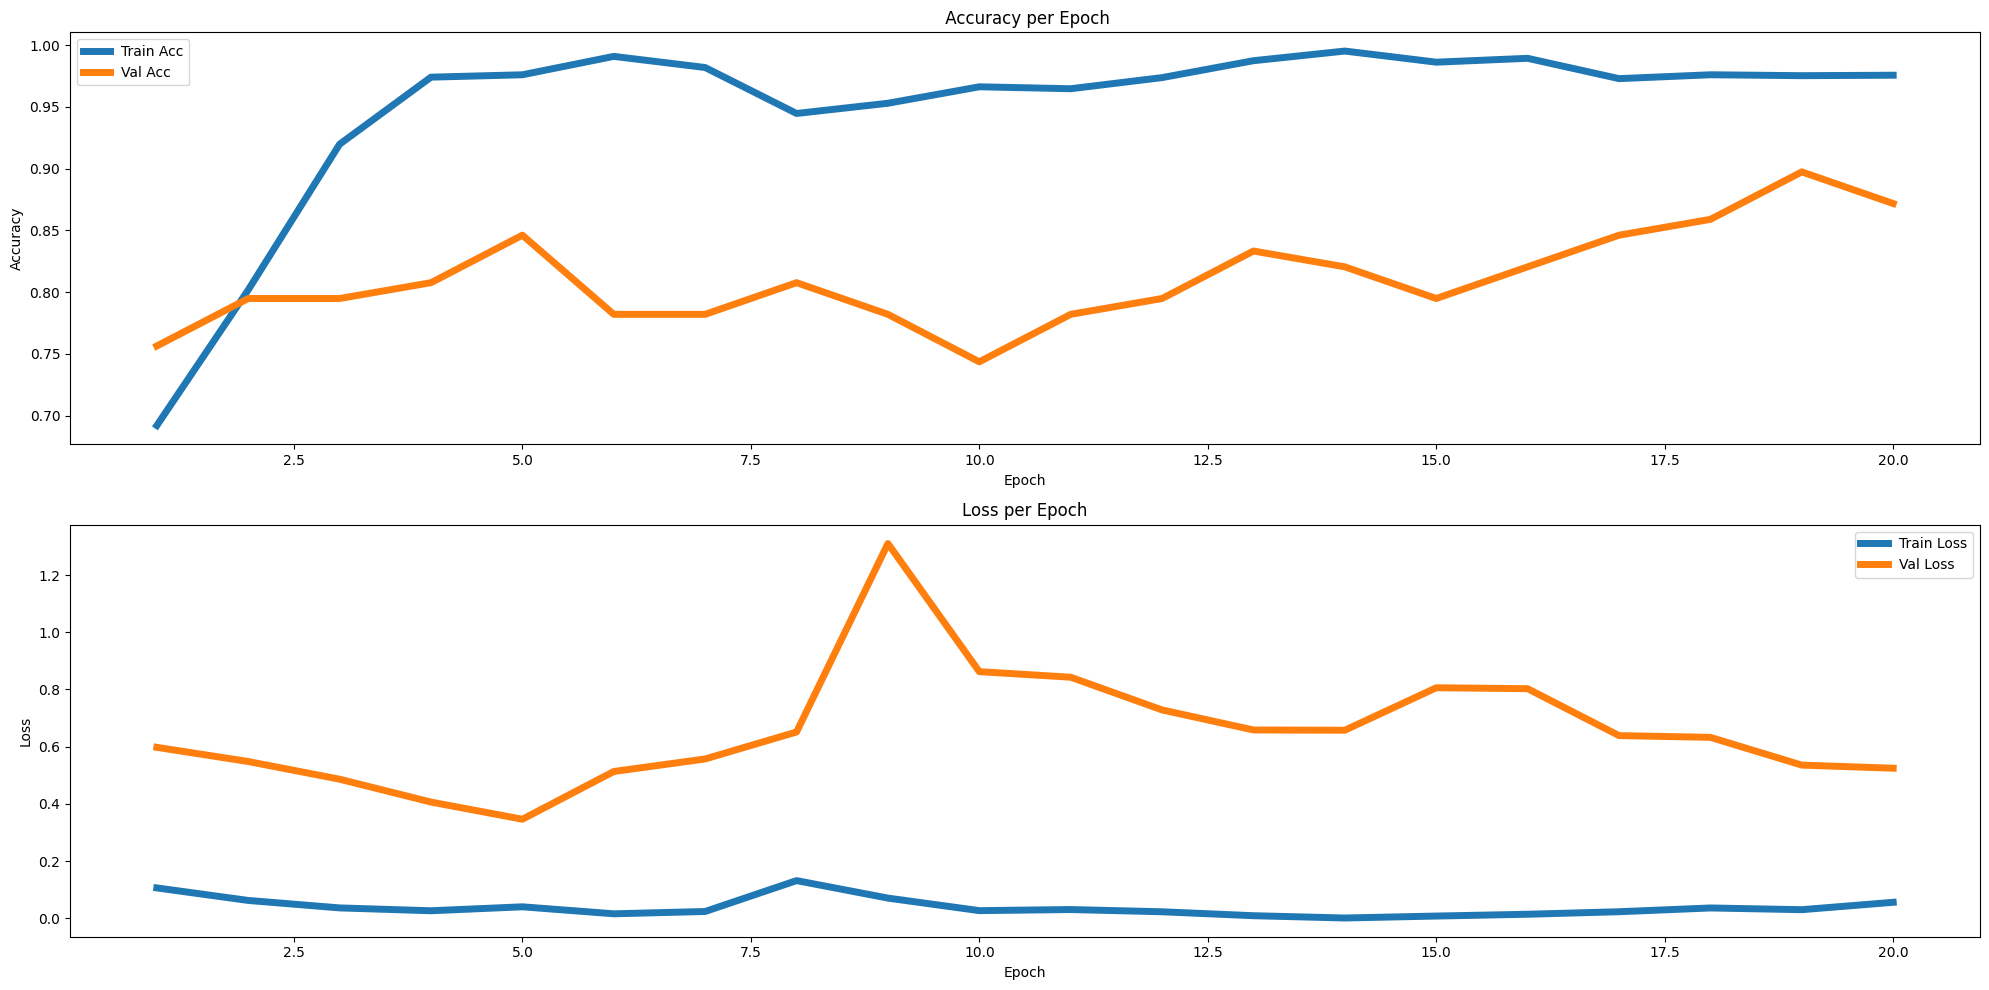

In [22]:
plot_acc_loss(resnet50_train_loss, resnet50_train_acc, resnet50_val_loss, resnet50_val_acc)

In [23]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def conf_acc(true, pred):
  cnf_matrix = confusion_matrix(true, pred)   ## Sklearn confusion matrix object
  accuracy = np.trace(cnf_matrix) / float(np.sum(cnf_matrix))
  misclass = 1 - accuracy

  fig, ax = plt.subplots()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap = "Blues" ,fmt='g', xticklabels=classes , yticklabels=classes)
  ax.xaxis.set_label_position("bottom")
  # plt.title('Confusion matrix for '+ model_name, y=1.1)
  plt.ylabel('True label')
  plt.xlabel('Predicted label\naccuracy={:0.2f}; misclass={:0.2f}'.format(accuracy, misclass))
  plt.tight_layout()
  print(classification_report(true, pred, digits=4))


In [24]:
def Testing(model, data_loader, criterion):
  test_running_acc = 0.0
  test_running_loss=0.00
  counter = 0
  test_acc = 0.0
  y_true_list = []
  y_pred_list = []

  # Send model to GPU
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model.eval()
  loss_fn = criterion
  test_loss, test_acc, counter = 0, 0, 0
  true = []
  pred = []
  with tqdm(data_loader, desc ="   test") as test_tqdm:
    for item in test_tqdm:
       counter += 1
       data = item['img'].type(torch.FloatTensor).to('cuda')
       label = item['label'].to(torch.float32).to('cuda')
       y_pred = model(data.unsqueeze(dim=1).to('cuda'))   # Calculate outputs using the model
       y_pred_list.append(y_pred.unsqueeze(dim=1))

       for i in range(label.shape[0]):
        true.append(label[i].detach().cpu().numpy().argmax())
        pred.append(y_pred[i].detach().cpu().numpy().argmax())

       loss = criterion(y_pred, label)     ## Calculate Loss
       test_running_loss += loss.item()
       loss.backward()   ## Backpropage the loss and calculate the gradients

       test_acc = accuracy_fn(label, y_pred)
       test_running_acc += test_acc
       test_tqdm.set_postfix(test_acc="{:.3f}".format(test_running_acc/counter),
                               test_loss=test_running_loss/counter)
    test_loss = loss / counter ## Total epoch loss
    test_acc = test_running_acc / counter ## Total epoch loss
  conf_acc(true, pred)
  return test_loss, test_acc

   test: 100%|██████████| 2/2 [00:00<00:00, 10.50it/s, test_acc=0.801, test_loss=0.847]


              precision    recall  f1-score   support

           0     0.6452    0.4762    0.5479        42
           1     0.8240    0.9035    0.8619       114

    accuracy                         0.7885       156
   macro avg     0.7346    0.6898    0.7049       156
weighted avg     0.7759    0.7885    0.7774       156



(tensor(0.3919, device='cuda:0', grad_fn=<DivBackward0>), 0.8013392857142857)

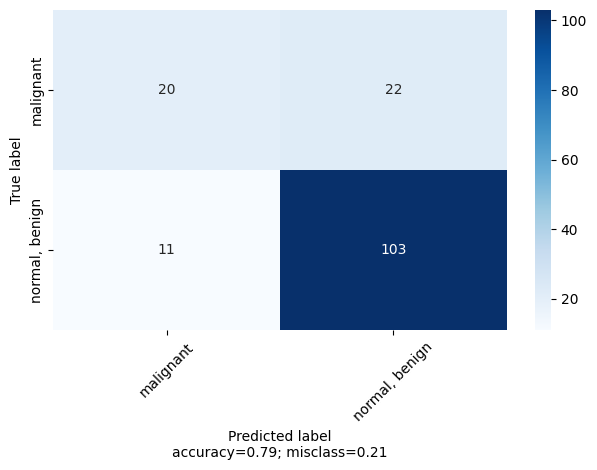

In [25]:
Testing(model, test_loader, criterion)

# **Conditional DCGAN**

In [26]:
class Discriminator(nn.Module):
  """ D(x) """
  def __init__(self):
    # initalize super module
    super(Discriminator, self).__init__()
    # creating layer for image input , input size : (batch_size, 1, 28, 28)
    self.layer_x = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=32,
                                           kernel_size=4, stride=2, padding=1, bias=False),
                                 # out size : (batch_size, 32, 14, 14)
                                 nn.LeakyReLU(0.2, inplace=True),
                                 # out size : (batch_size, 32, 14, 14)
                                )
    # creating layer for label input, input size : (batch_size, 2, 28, 28)
    self.layer_y = nn.Sequential(nn.Conv2d(in_channels=2, out_channels=32,
                                           kernel_size=4, stride=2, padding=1, bias=False),
                                 # out size : (batch_size, 32, 14, 14)
                                 nn.LeakyReLU(0.2, inplace=True),
                                 # out size : (batch_size, 32, 14, 14)
                                 )
    # layer for concat of image layer and label layer, input size : (batch_size, 64, 14, 14)
    self.layer_xy = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=128,
                                            kernel_size=4, stride=2, padding=1, bias=False),
                               # out size : (batch_size, 128, 7, 7)
                               nn.BatchNorm2d(128),
                               # out size : (batch_size, 128, 7, 7)
                               nn.LeakyReLU(0.2, inplace=True),
                               # out size : (batch_size, 128, 7, 7)
                               nn.Conv2d(in_channels=128, out_channels=256,
                                         kernel_size=3, stride=2, padding=0, bias=False),
                               # out size : (batch_size, 256, 3, 3)
                               nn.BatchNorm2d(256),
                               # out size : (batch_size, 256, 3, 3)
                               nn.LeakyReLU(0.2, inplace=True),
                               # out size : (batch_size, 256, 3, 3)
                               nn.Conv2d(in_channels=256, out_channels=1,
                                         kernel_size=3, stride=1, padding=0, bias=False),
                               # out size : (batch_size, 1, 1, 1)
                               # sigmoid layer to convert in [0,1] range
                               nn.Sigmoid()
                               )

  def forward(self, x, y):
    # size of x : (batch_size, 1, 28, 28)
    x = self.layer_x(x)
    # size of x : (batch_size, 32, 14, 14)
    # size of y : (batch_size, 2, 28, 28)
    y = self.layer_y(y)
    # size of y : (batch_size, 32, 14, 14)
    # concat image layer and label layer output
    xy = torch.cat([x,y], dim=1)
    # size of xy : (batch_size, 64, 14, 14)
    xy = self.layer_xy(xy)
    # size of xy : (batch_size, 1, 1, 1)
    xy = xy.view(xy.shape[0], -1)
    # size of xy : (batch_size, 1) ## FAKE or REAL
    return xy

In [27]:
# Create the Discriminator
netD = Discriminator().to(device)
print(netD)

Discriminator(
  (layer_x): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer_y): Sequential(
    (0): Conv2d(2, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer_xy): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(256, 1, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (7): Sigmoid()
  )
)


In [28]:
class Generator(nn.Module):
  """ G(z) """
  def __init__(self, input_size=4):
    # initalize super module
    super(Generator, self).__init__()
    # noise z input layer : (batch_size, 100, 1, 1)
    self.layer_x = nn.Sequential(nn.ConvTranspose2d(in_channels=4, out_channels=128, kernel_size=3,
                                                  stride=1, padding=0, bias=False),
                                 # out size : (batch_size, 128, 3, 3)
                                 nn.BatchNorm2d(128),
                                 # out size : (batch_size, 128, 3, 3)
                                 nn.ReLU(),
                                 # out size : (batch_size, 128, 3, 3)
                                )
    # label input layer : (batch_size, 2, 1, 1)
    self.layer_y = nn.Sequential(nn.ConvTranspose2d(in_channels=2, out_channels=128, kernel_size=3,
                                                  stride=1, padding=0, bias=False),
                                 # out size : (batch_size, 128, 3, 3)
                                 nn.BatchNorm2d(128),
                                 # out size : (batch_size, 128, 3, 3)
                                 nn.ReLU(),
                                 # out size : (batch_size, 128, 3, 3)
                                )
    # noise z and label concat input layer : (batch_size, 256, 3, 3)
    self.layer_xy = nn.Sequential(nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3,
                                                  stride=2, padding=0, bias=False),
                               # out size : (batch_size, 128, 7, 7)
                               nn.BatchNorm2d(128),
                               # out size : (batch_size, 128, 7, 7)
                               nn.ReLU(),
                               # out size : (batch_size, 128, 7, 7)
                               nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4,
                                                  stride=2, padding=1, bias=False),
                               # out size : (batch_size, 64, 14, 14)
                               nn.BatchNorm2d(64),
                               # out size : (batch_size, 64, 14, 14)
                               nn.ReLU(),
                               # out size : (batch_size, 64, 14, 14)
                               nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=4,
                                                  stride=2, padding=1, bias=False),
                               # out size : (batch_size, 1, 28, 28)
                               nn.Tanh())
                               # out size : (batch_size, 1, 28, 28)

  def forward(self, x, y):
    # x size : (batch_size, 100)
    x = x.view(x.shape[0], x.shape[1], 1, 1) #reshape
    # x size : (batch_size, 100, 1, 1)
    x = self.layer_x(x)
    # x size : (batch_size, 128, 3, 3)

    # y size : (batch_size, 2)
    y = y.view(y.shape[0], y.shape[1], 1, 1)
    # y size : (batch_size, 2, 1, 1)
    y = self.layer_y(y)
    # y size : (batch_size, 128, 3, 3)

    # concat x and y
    xy = torch.cat([x,y], dim=1)
    # xy size : (batch_size, 256, 3, 3)
    xy = self.layer_xy(xy)
    # xy size : (batch_size, 1, 28, 28) ## FAKE IMAGE
    return xy

In [29]:
# Create the Generator
netG = Generator().to(device)
print(netG)

Generator(
  (layer_x): Sequential(
    (0): ConvTranspose2d(4, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer_y): Sequential(
    (0): ConvTranspose2d(2, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer_xy): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): Tanh()
  )
)


In [30]:
# custom weights initialization
def weights_init(net):
    classname = net.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(net.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(net.weight.data, 1.0, 0.02)
        nn.init.constant_(net.bias.data, 0)

In [31]:
# randomly initialize all weights to mean=0, stdev=0.2.
netD.apply(weights_init)
netG.apply(weights_init)

Generator(
  (layer_x): Sequential(
    (0): ConvTranspose2d(4, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer_y): Sequential(
    (0): ConvTranspose2d(2, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer_xy): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): Tanh()
  )
)

In [32]:
# number of training epochs
NUM_EPOCH = 10000
# size of latent vector z
size_z = 4
# number of discriminator steps for each generator step
Ksteps = 5
# learning rate of adam
Adam_lr = 0.001
# DCGAN recommend 0.5
Adam_beta1 = 0.5

In [33]:
# We calculate Binary cross entropy loss
criterion = nn.BCELoss()
# Adam optimizer for generator
optimizerG = torch.optim.Adam(netG.parameters(), lr=Adam_lr, betas=(Adam_beta1, 0.999))

# Adam optimizer for discriminator
optimizerD = torch.optim.Adam(netD.parameters(), lr=Adam_lr, betas=(Adam_beta1, 0.999))

In [34]:
# Fix noise for testing generator and visualization
z_test = torch.randn(4, size_z).to(device)

In [35]:
# convert labels to onehot encoding
onehot = torch.zeros(2, 2).scatter_(1, torch.tensor([0, 1]).view(2,1), 1)
# reshape labels to image size, with number of labels as channel
fill = torch.zeros([2, 2, 28, 28])
#channel corresponding to label will be set one and all other zeros
for i in range(2):
    fill[i, i, :, :] = 1
print(fill.shape)

torch.Size([2, 2, 28, 28])


In [ ]:
#******************************* TRAINING THE CDCGAN ****************************************#
D_losses = []
G_losses = []
Dx_values = []
DGz_values = []

# number of training steps done on discriminator
step = 0
for epoch in range(NUM_EPOCH):
  epoch_D_losses = []
  epoch_G_losses = []
  epoch_Dx = []
  epoch_DGz = []
  # iterate through data loader generator object
  for item in train_loader:
    step += 1
    ############################
    # Update D network: maximize log(D(x)) + log(1 - D(G(z)))
    ###########################
    # images will be send to gpu, if cuda available
    ### FEEDING REAL IMAGES TO DISCRIMINATOR
    x = (item['img'].type(torch.FloatTensor)/255).unsqueeze(dim=1).to(device) # (batch, 1, 28, 28)
    # preprocess labels for feeding as y input
    # D_y shape will be (batch_size, 2, 28, 28)
    temp=[]
    for i in range(item['label'].shape[0]):
      if(torch.all(torch.eq(item['label'][i], torch.tensor([0, 1])))):
        temp.append(1) # (batch, 2, 28, 28):
      elif(torch.all(torch.eq(item['label'][i], torch.tensor([1, 0])))):
        temp.append(0) # (batch, 2, 28, 28):

    D_y = fill[temp].to(device) # (batch, 2, 28, 28)
    # forward pass D(x)
    x_preds = netD(x, D_y) # (batch, 1) ## predicted fake or real
    # calculate loss log(D(x))
    labels_real = torch.ones((item['label'].shape[0], 1)).to(device) # (batch, 1) ## REAL: cause we are using dataset images
    D_x_loss = criterion(x_preds, labels_real)

    ### CREATING FAKE IMAGE AND FEEDING IT TO DISCRIMINATOR
    # create latent vector z from normal distribution
    z = torch.randn(BATCH_SIZE, size_z).to(device) # (batch, 100)
    # create random y labels for generator
    y_gen = (torch.rand(BATCH_SIZE, 1)*2).type(torch.LongTensor).squeeze() # (batch) ##generator labels
    # convert genarator labels to onehot
    G_y = onehot[y_gen].to(device) # (batch, 2)  ## Generator labels : one hot format
    # preprocess labels for feeding as y input in D
    # DG_y shape will be (batch_size, 2, 28, 28)
    fill = torch.zeros([2, 2, 28, 28])
    for i in range(2):
      fill[i, i, :, :] = 1
    DG_y = fill[y_gen].to(device) # (batch_size, 2, 28, 28) ## fake labels for discriminator

    # generate image
    fake_image = netG(z, G_y) # (batch, 1, 28, 28)
    # calculate D(G(z)), fake or not
    z_preds = netD(fake_image.detach(), DG_y) #(batch, 1)
    # loss log(1 - D(G(z)))
    labels_fake = torch.zeros((z_preds.shape[0], 1)).to(device) #(batch, 1)
    D_z_loss = criterion(z_preds, labels_fake)

    # total loss = log(D(x)) + log(1 - D(G(z)))
    D_loss = D_x_loss + D_z_loss

    # save values for plots
    epoch_D_losses.append(D_loss.item())
    epoch_Dx.append(x_preds.mean().item())

    # zero accumalted grads
    netD.zero_grad()
    # do backward pass
    D_loss.backward()
    # update discriminator model
    optimizerD.step()

    ############################
    # Update G network: maximize log(D(G(z)))
    ###########################

    # if Ksteps of Discriminator training are done, update generator
    if step % Ksteps == 0:
      # As we done one step of discriminator, again calculate D(G(z))
      z_out = netD(fake_image, DG_y)
      # loss log(D(G(z)))
      labels_real = torch.ones((fake_image.shape[0], 1)).to(device)
      # print(z_out.shape,  labels_real.shape)
      G_loss = criterion(z_out, labels_real)
      # save values for plots
      epoch_DGz.append(z_out.mean().item())
      epoch_G_losses.append(G_loss)

      # zero accumalted grads
      netG.zero_grad()
      # do backward pass
      G_loss.backward()
      # update generator model
      optimizerG.step()

  else:
    D_losses.append(sum(epoch_D_losses)/len(epoch_D_losses))
    G_losses.append(sum(epoch_G_losses)/len(epoch_G_losses))
    Dx_values.append(sum(epoch_Dx)/len(epoch_Dx))
    DGz_values.append(sum(epoch_DGz)/len(epoch_DGz))

    print(f" Epoch {epoch+1}/{NUM_EPOCH} Discriminator Loss {D_losses[-1]:.3f} Generator Loss {G_losses[-1]:.3f}"
         + f" D(x) {Dx_values[-1]:.3f} D(G(x)) {DGz_values[-1]:.3f}")

Streaming output truncated to the last 5000 lines.
 Epoch 5001/10000 Discriminator Loss 0.458 Generator Loss 2.294 D(x) 0.900 D(G(x)) 0.113
 Epoch 5002/10000 Discriminator Loss 0.179 Generator Loss 3.220 D(x) 0.912 D(G(x)) 0.105
 Epoch 5003/10000 Discriminator Loss 0.359 Generator Loss 2.895 D(x) 0.870 D(G(x)) 0.246
 Epoch 5004/10000 Discriminator Loss 0.804 Generator Loss 2.683 D(x) 0.814 D(G(x)) 0.213
 Epoch 5005/10000 Discriminator Loss 0.566 Generator Loss 2.519 D(x) 0.886 D(G(x)) 0.275
 Epoch 5006/10000 Discriminator Loss 0.719 Generator Loss 1.712 D(x) 0.799 D(G(x)) 0.372
 Epoch 5007/10000 Discriminator Loss 0.445 Generator Loss 2.497 D(x) 0.865 D(G(x)) 0.196
 Epoch 5008/10000 Discriminator Loss 0.430 Generator Loss 3.111 D(x) 0.892 D(G(x)) 0.062
 Epoch 5009/10000 Discriminator Loss 0.374 Generator Loss 1.936 D(x) 0.897 D(G(x)) 0.179
 Epoch 5010/10000 Discriminator Loss 0.494 Generator Loss 2.386 D(x) 0.821 D(G(x)) 0.220
 Epoch 5011/10000 Discriminator Loss 0.629 Generator Loss 3

In [ ]:
gg = torch.tensor(G_losses).numpy()

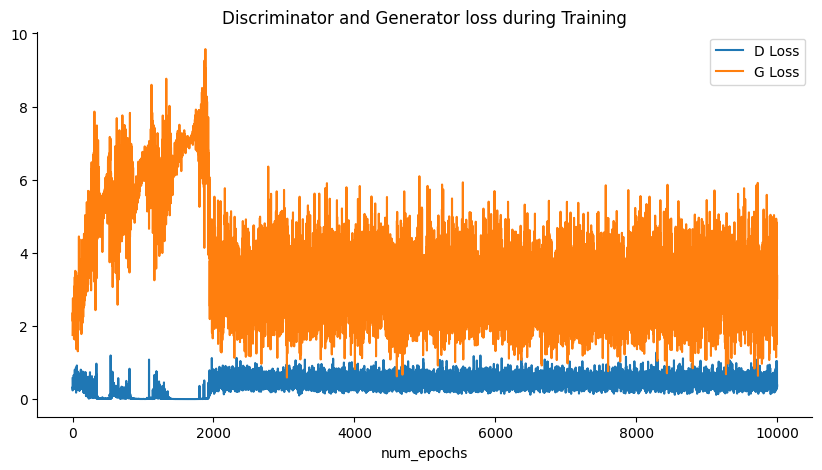

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Discriminator and Generator loss during Training")
# plot Discriminator and generator loss
plt.plot(D_losses,label="D Loss")
plt.plot(gg,label="G Loss")
# get plot axis
ax = plt.gca()
# remove right and top spine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# add labels and create legend
plt.xlabel("num_epochs")
plt.legend()
plt.show()

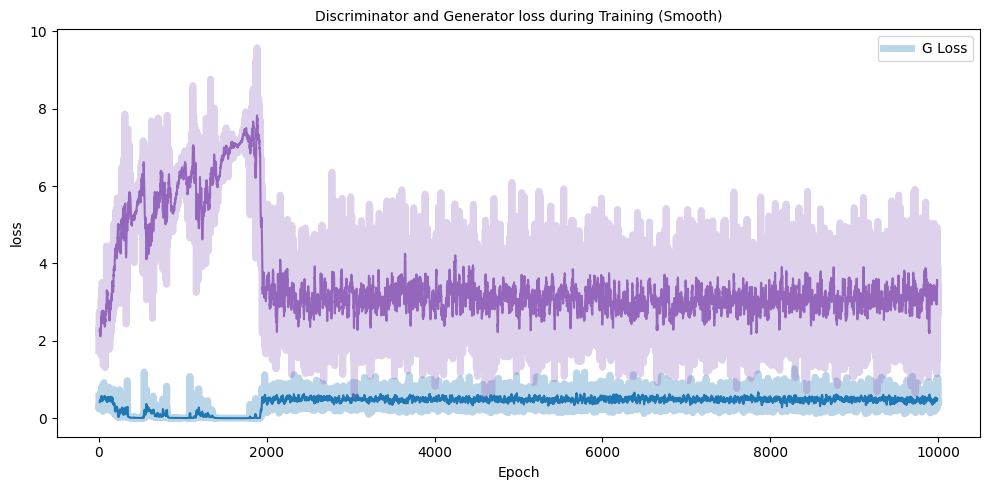

In [ ]:
def smooth(y, box_pts):
                    box = np.ones(box_pts)/box_pts
                    y_smooth = np.convolve(y, box, mode='same')
                    return y_smooth
xs = [_ for _ in range(len(gg))]
w = 10

# f, axs = plt.subplots(2, figsize=(8,4))
plt.figure(figsize=(10,5))
# plt.xkcd()
plt.plot(D_losses, alpha=0.3, linewidth=5)
plt.plot(xs[w:-w], smooth(D_losses, w)[w:-w], c='C0')
plt.legend(['D Loss'])
plt.title('Discriminator and Generator loss during Training (Smooth)', fontsize=10)
# plt.yscale('log')
plt.ylabel('loss', fontsize=10)
# plt.xkcd()
plt.plot(gg, alpha=0.3, linewidth=5, c='C4')
plt.plot(xs[w:-w], smooth(gg, w)[w:-w], c='C4')
# plt.set_title('Generator', fontsize=10)
plt.xlabel('Epoch')
# plt.set_ylabel('loss', fontsize=10)
plt.legend(['G Loss'])
plt.tight_layout()


In [ ]:
torch.save(netD.state_dict(), 'Discriminator')
torch.save(netG.state_dict(), 'Generator')


# **Classification with ResNet using the new Dataset**

In [36]:
netG.load_state_dict(torch.load('Generator'))

<All keys matched successfully>

In [37]:
## checking the imbalancy
print(f'all train data:{train_dataset.labels.shape[0]}\nnumber of data in class 1 : {sum(train_dataset.labels.squeeze())}\nnumber of data in class 0 : {train_dataset.labels.shape[0] - sum(train_dataset.labels.squeeze())}')

all train data:546
number of data in class 1 : 399
number of data in class 0 : 147


In [38]:
# picking random data from generated images
train_num = 1500
import random
randomlist_class0 = random.sample(range(1, 2000), train_num-sum(train_dataset.labels.squeeze()))
randomlist_class1 = random.sample(range(1, 2000), train_num-(train_dataset.labels.shape[0] - sum(train_dataset.labels.squeeze())))

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [40]:
import os.path as osp
# Creating 2000 fake images for class 1
SAVE_DIR = "./drive/MyDrive/class_1/"
test_Gy = torch.tensor([[0, 1]]).type(torch.FloatTensor).to(device)
count = 0
class_1_df = pd.DataFrame(columns = ['img', 'label'])
val_1_df = pd.DataFrame(columns = ['img', 'label'])
save_img_dir = osp.join(SAVE_DIR)

for i in range(2000):
  if not osp.exists(save_img_dir):
    os.makedirs(save_img_dir)
  z_test = torch.randn(1, size_z).to(device)
  fake_test = netG(z_test, test_Gy).cpu()
  if i in randomlist_class1:
    # fake train data
    new_df = pd.DataFrame([{'img':fake_test.reshape([28, 28]).detach().cpu().numpy(), 'label' : 1}])
    class_1_df = pd.concat([class_1_df, new_df], axis=0)
  else:
    # fake validation data
    new_df = pd.DataFrame([{'img':fake_test.reshape([28, 28]).detach().cpu().numpy(), 'label' : 1}])
    val_1_df = pd.concat([val_1_df, new_df], axis=0)
  # save the image
  torchvision.utils.save_image(fake_test, f"{save_img_dir}/sample_{count}_class_1.jpg",nrow=10, padding=0, normalize=True)
  count+=1

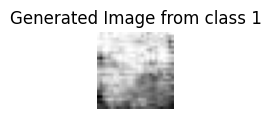

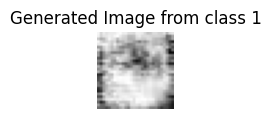

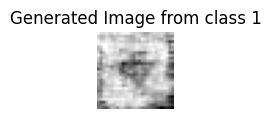

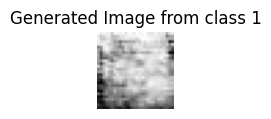

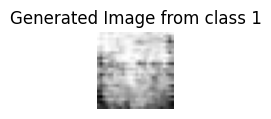

In [41]:
# Visualize a sample data from class 1
SAVE_DIR = "./drive/MyDrive/class_1/"
save_img_dir = osp.join(SAVE_DIR)
for i in range (5):
  plt.figure(figsize=(1, 1))
  plt.axis("off")
  plt.title("Generated Image from class 1")
  # using _ for avoiding extra outputs
  _ = plt.imshow(Image.open(f"{save_img_dir}/sample_{randomlist_class1[i]}_class_1.jpg"))

In [42]:
import os.path as osp
# Creating 2000 fake images for class 0
SAVE_DIR = "./drive/MyDrive/class_0/"
test_Gy = torch.tensor([[1, 0]]).type(torch.FloatTensor).to(device)
count = 0
save_img_dir = osp.join(SAVE_DIR)
class_0_df = pd.DataFrame(columns = ['img', 'label'])
val_0_df = pd.DataFrame(columns = ['img', 'label'])
for i in range(2000):
  if not osp.exists(save_img_dir):
    os.makedirs(save_img_dir)
  z_test = torch.randn(1, size_z).to(device)
  fake_test = netG(z_test, test_Gy).cpu()
  if i in randomlist_class0:
    # fake train data
    new_df = pd.DataFrame([{'img':fake_test.reshape([28, 28]).detach().cpu().numpy(), 'label' : 0}])
    class_0_df = pd.concat([class_0_df, new_df], axis=0)
  else:
    # fake validation data
    new_df = pd.DataFrame([{'img':fake_test.reshape([28, 28]).detach().cpu().numpy(), 'label' : 0}])
    val_0_df = pd.concat([val_0_df, new_df], axis=0)
  # save the image
  torchvision.utils.save_image(fake_test, f"{save_img_dir}/sample_{count}_class_0.jpg",nrow=5, padding=0, normalize=True)
  count+=1

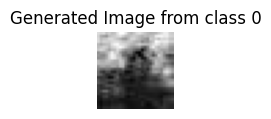

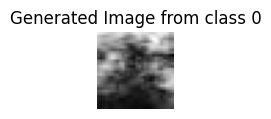

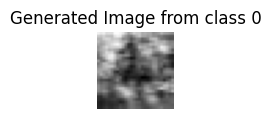

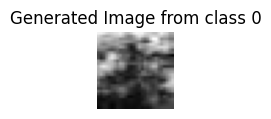

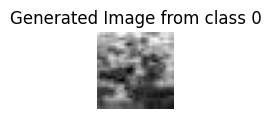

In [43]:
# Visualize a sample data from class 0
SAVE_DIR = "./drive/MyDrive/class_0/"
save_img_dir = osp.join(SAVE_DIR)
for i in range(5):
  plt.figure(figsize=(1, 1))
  plt.axis("off")
  plt.title("Generated Image from class 0")
  # using _ for avoiding extra outputs
  _ = plt.imshow(Image.open(f"{save_img_dir}/sample_{randomlist_class0[i]}_class_0.jpg"))

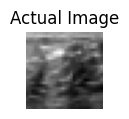

In [44]:
plt.figure(figsize=(1, 1))
plt.axis("off")
plt.title("Actual Image")
_ = plt.imshow(Train_set[2]['img'], cmap='gray')

In [45]:
# train and validation data frames
train_df = pd.DataFrame(columns = ['img', 'label'])
val_df = pd.DataFrame(columns = ['img', 'label'])
# Inserting the original data
for i in range(train_dataset.imgs.shape[0]):
  list_row = [train_dataset.imgs[i], train_dataset.labels[i][0]]
  train_df.loc[i] = list_row

for i in range(val_dataset.imgs.shape[0]):
  list_row = [val_dataset.imgs[i], val_dataset.labels[i][0]]
  val_df.loc[i] = list_row

In [53]:
# creating final val data (fake and original)
final_val_df = pd.DataFrame(columns = ['img', 'label'])
final_val_df = pd.concat([val_0_df, val_1_df, val_df], axis=0, ignore_index=True)
final_val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1624 entries, 0 to 1623
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   img     1624 non-null   object
 1   label   1624 non-null   object
dtypes: object(2)
memory usage: 25.5+ KB


In [54]:
# creating final train data (fake and original)
final_train_df = pd.DataFrame(columns = ['img', 'label'])
final_train_df = pd.concat([class_0_df, class_1_df, train_df], axis=0, ignore_index=True)
final_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   img     3000 non-null   object
 1   label   3000 non-null   object
dtypes: object(2)
memory usage: 47.0+ KB


In [55]:
## creating train  dataset
new_train_set = []
for i in range(final_train_df.shape[0]):
  data = torch.tensor(final_train_df['img'][i])
  if(final_train_df['label'][i] == 1):
    label = torch.tensor([0,1])
  else:
    label = torch.tensor([1,0])
  m = {'label': label,
      'img':data}
  new_train_set.append(m)

## creating val  dataset
new_val_set = []
for i in range(final_val_df.shape[0]):
  data = torch.tensor(final_val_df['img'][i])
  if(final_val_df['label'][i] == 1):
    label = torch.tensor([0,1])
  else:
    label = torch.tensor([1,0])
  m = {'label': label,
      'img':data}
  new_val_set.append(m)
## creating dataloaders
new_train_loader = DataLoader(dataset=new_train_set, batch_size=128, shuffle=True)
new_val_loader = DataLoader(dataset=new_val_set, batch_size=128, shuffle=True)

In [56]:
## training
import torch.optim as optim

model_new = resnet().to(device)
optimizer = optim.Adam(model.parameters(),lr=0.0002)
criterion = nn.BCELoss()
epochs = 20

new_train_loss, new_train_acc, new_val_loss, new_val_acc = train(new_train_loader, new_val_loader, model_new, optimizer, criterion, epochs)

EPOCH 1/20 :


  val: 100%|██████████| 13/13 [00:00<00:00, 15.69it/s, val_acc=0.988, val_loss=0.0222]


EPOCH 2/20 :


  val: 100%|██████████| 13/13 [00:00<00:00, 14.91it/s, val_acc=0.776, val_loss=0.642]


EPOCH 3/20 :


  val: 100%|██████████| 13/13 [00:00<00:00, 15.20it/s, val_acc=0.632, val_loss=1.44]


EPOCH 4/20 :


  val: 100%|██████████| 13/13 [00:00<00:00, 15.73it/s, val_acc=0.445, val_loss=3.02]


EPOCH 5/20 :


  val: 100%|██████████| 13/13 [00:00<00:00, 16.13it/s, val_acc=0.991, val_loss=0.0253]


EPOCH 6/20 :


  val: 100%|██████████| 13/13 [00:00<00:00, 15.81it/s, val_acc=0.991, val_loss=0.023]


EPOCH 7/20 :


  val: 100%|██████████| 13/13 [00:00<00:00, 15.74it/s, val_acc=0.995, val_loss=0.0171]


EPOCH 8/20 :


  val: 100%|██████████| 13/13 [00:00<00:00, 14.83it/s, val_acc=0.989, val_loss=0.0322]


EPOCH 9/20 :


  val: 100%|██████████| 13/13 [00:00<00:00, 15.60it/s, val_acc=0.603, val_loss=1.33]


EPOCH 10/20 :


  val: 100%|██████████| 13/13 [00:00<00:00, 16.02it/s, val_acc=0.989, val_loss=0.0806]


EPOCH 11/20 :


  val: 100%|██████████| 13/13 [00:00<00:00, 15.93it/s, val_acc=0.994, val_loss=0.0188]


EPOCH 12/20 :


  val: 100%|██████████| 13/13 [00:00<00:00, 15.96it/s, val_acc=0.992, val_loss=0.0278]


EPOCH 13/20 :


  val: 100%|██████████| 13/13 [00:00<00:00, 15.59it/s, val_acc=0.993, val_loss=0.025]


EPOCH 14/20 :


  val: 100%|██████████| 13/13 [00:00<00:00, 14.74it/s, val_acc=0.995, val_loss=0.0238]


EPOCH 15/20 :


  val: 100%|██████████| 13/13 [00:00<00:00, 13.44it/s, val_acc=0.995, val_loss=0.0158]


EPOCH 16/20 :


  val: 100%|██████████| 13/13 [00:00<00:00, 16.18it/s, val_acc=0.993, val_loss=0.0235]


EPOCH 17/20 :


  val: 100%|██████████| 13/13 [00:00<00:00, 16.11it/s, val_acc=0.996, val_loss=0.0168]


EPOCH 18/20 :


  val: 100%|██████████| 13/13 [00:00<00:00, 16.13it/s, val_acc=0.995, val_loss=0.0184]


EPOCH 19/20 :


  val: 100%|██████████| 13/13 [00:00<00:00, 15.04it/s, val_acc=0.995, val_loss=0.0212]


EPOCH 20/20 :


  val: 100%|██████████| 13/13 [00:00<00:00, 15.94it/s, val_acc=0.996, val_loss=0.0263]


In [57]:
print(f"Mean train_acc during training (new dataset): {(sum(new_train_acc)/len(new_train_acc))*100}\nMean val_acc during training (new dataset): {(sum(new_val_acc)/len(new_val_acc))*100}")

Mean train_acc during training (new dataset): 98.86881510416667
Mean val_acc during training (new dataset): 91.70126748251747


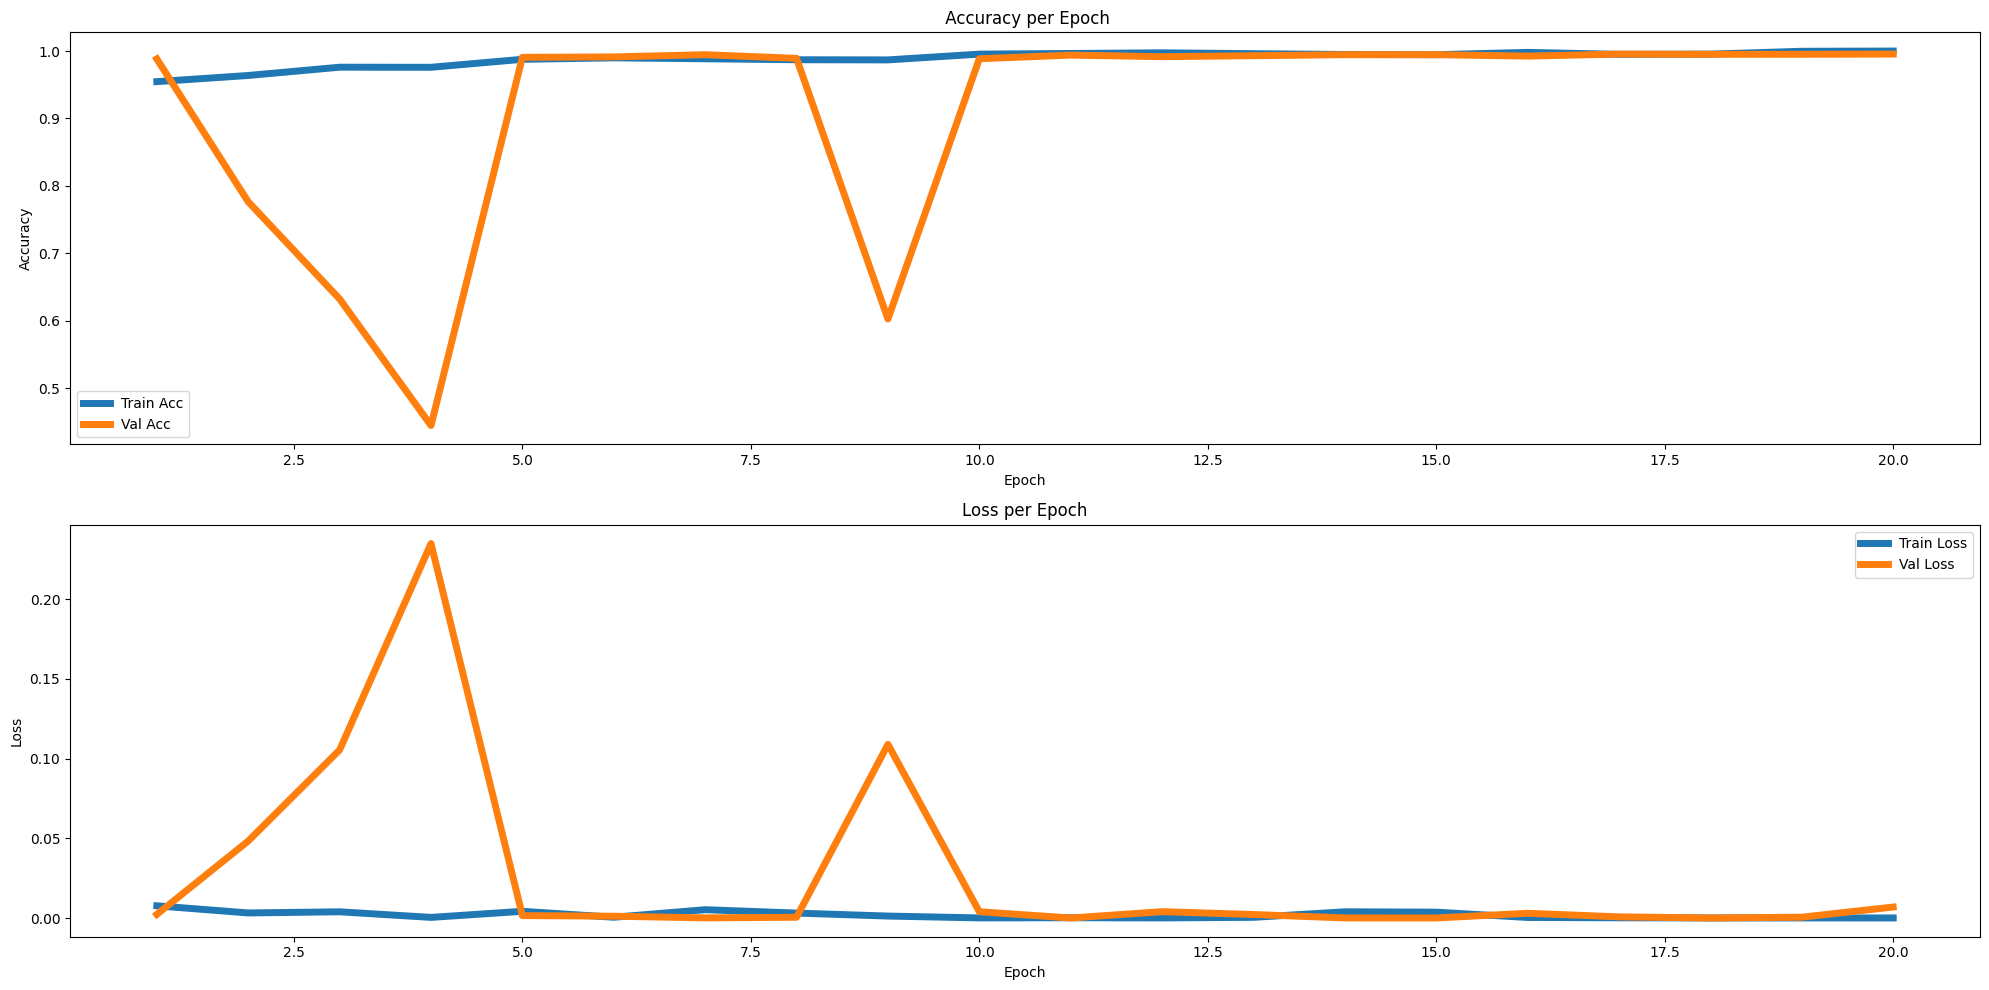

In [58]:
plot_acc_loss(new_train_loss, new_train_acc, new_val_loss, new_val_acc)

   test: 100%|██████████| 2/2 [00:00<00:00, 10.90it/s, test_acc=0.860, test_loss=0.69]


              precision    recall  f1-score   support

           0     0.8529    0.6905    0.7632        42
           1     0.8934    0.9561    0.9237       114

    accuracy                         0.8846       156
   macro avg     0.8732    0.8233    0.8434       156
weighted avg     0.8825    0.8846    0.8805       156



(tensor(0.3459, device='cuda:0', grad_fn=<DivBackward0>), 0.8599330357142857)

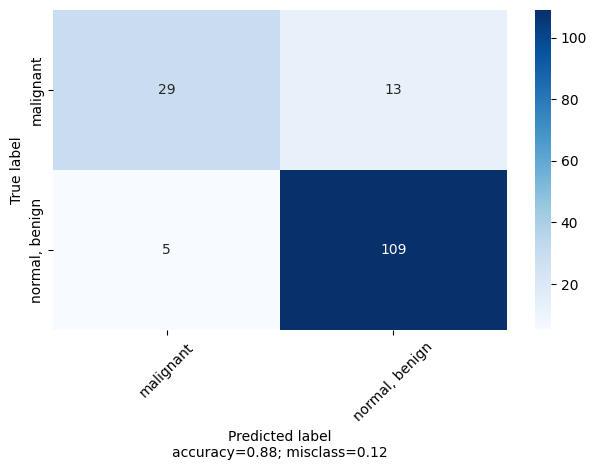

In [59]:
Testing(model_new, test_loader, criterion)